## 导入必要的安装包

In [1]:
import pandas as pd
import numpy as np
import tushare as ts
import os 
from tqdm import tqdm
import glob
ts.set_token('ce1d8f98f48f0c92fa70a66528612510f350b82ea565bc1abd45b5ac')
debug = False
from datetime import datetime 
pro = ts.pro_api()

In [2]:
# !pip install openpyxl

## 生成Alpha因子的基础函数

In [3]:
def ts_sum(df, window=10):
    return df.rolling(window).sum()

def sma(df, window=10):
    return df.rolling(window).mean()

def ts_min(df, window=10):
    return df.rolling(window).min()

def ts_median(df, window=10):
    return df.rolling(window).median()

def ts_max(df, window=10):
    return df.rolling(window).max()

def delta(df, period=1):
    return df.diff(period)

def delay(df, period=1):
    return df.shift(period)

def rank(df):
    return df.rank(axis=1, pct=True)

def ts_argmax(df, window=10):
    return df.rolling(window).apply(np.argmax) + 1 


## 一系列Alpha因子

In [4]:

class AlphaLib(object):
    def __init__(self, daily_info):
        self.open = daily_info['open']
        self.high = daily_info['high']
        self.low = daily_info['low']
        self.close = daily_info['close']
        self.vwap = daily_info['vwap'] 
        self.volume = daily_info['volume'] 
        self.amount = daily_info['amount']

    def calcu_alpha(self):
        alpha_dict={}
#         alpha_dict['alpha01']=((self.close/sma(self.close,10)-1)*self.amount).div(self.amount.sum(1),axis=0)
#         alpha_dict['alpha02']=sma(self.amount,5).div(self.amount.sum(1),axis=0)
#         alpha_dict['alpha06']=sma((self.close/sma(self.close, 5)-1)*self.amount,5).div(self.amount.sum(1),axis=0)
#         alpha_dict['alpha07']=ts_max((self.close/sma(self.close, 15)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
#         alpha_dict['alpha08']=ts_min((self.close/ts_max(self.close, 60)-1)*self.amount,10).div(self.amount.sum(1),axis=0)
#         alpha_dict['alpha09']=ts_max((self.close/ts_min(self.close, 60)-1)*self.amount,50).div(self.amount.sum(1),axis=0)
#         alpha_dict['alpha10']=ts_max((self.close/ts_min(self.close, 20)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
#         alpha_dict['alpha12']=ts_max((ts_max(self.high,30)/ts_min(self.low, 30)-1)*self.amount,20).div(self.amount.sum(1),axis=0)
#         alpha_dict['alpha13']=ts_max(self.high-self.low, 30)/ts_min(self.close+self.open, 30)
#         alpha_dict['alpha14']=ts_sum(self.amount*(self.close-self.open), 5)
#         alpha_dict['alpha15']=ts_max(self.amount*(self.high-self.low), 15)
#         alpha_dict['alpha16']=ts_sum(self.amount*(self.close-self.vwap), 5)
#         alpha_dict['alpha17']=ts_min(self.amount*(self.low-self.vwap), 15)
#         alpha_dict['alpha18']=ts_min(self.amount*(self.open-self.vwap), 15)
#         alpha_dict['alpha19']=ts_min(self.amount*(self.open-self.low), 10)
#         alpha_dict['alpha20']=ts_max(self.amount*(self.close-self.low), 10)
#         alpha_dict['alpha21']=ts_median(self.amount,15)/ts_sum(self.amount,15)
#         alpha_dict['alpha23']=ts_max(self.amount,15)/ts_min(self.amount,10)
#         alpha_dict['alpha24']=ts_sum(self.amount.div(self.amount.sum(1),axis=0),5)
#         alpha_dict['alpha28']=(ts_max(self.close,5)/delay(self.close,5))*ts_min(self.close,5)/self.close
      
#         tmp2=abs((self.close-self.open)/(self.high-self.low+0.01))
#         alpha_dict['alpha29']=ts_max(tmp2,6)/ts_min(tmp2,6)
#         alpha_dict['alpha30']=tmp2/delay(tmp2,4)

#         tmp3=abs((self.low-self.open)/(self.close-self.low+0.01))
#         alpha_dict['alpha31']=ts_max(tmp3,4)/ts_min(tmp3,4)

#         tmp4=abs((self.high-self.open)/(self.close-self.low+0.01))
#         alpha_dict['alpha32']=ts_max(tmp4,2)/ts_min(tmp4,2)
        
#         alpha_dict['alpha_w_005'] = (rank((self.open - (ts_sum(self.vwap, 10) / 10))) * (-1 * abs(rank((self.close - self.vwap)))))
#         alpha_dict['alpha_pe']= -1*daily_info['pe_ttm']
#         alpha_dict['alpha_total_mv']= daily_info['total_mv']
#         alpha_dict['alpha_pb']= -1*daily_info['pb']
#         alpha_dict['alpha_turnover_rate']= daily_info['turnover_rate']
#         alpha_dict['alpha_volume_ratio']= daily_info['volume_ratio']
#         alpha_dict['alpha_vwap']= daily_info['vwap']
#         alpha_dict['alpha_dv_ttm']= -1*daily_info['dv_ttm']
        
        alpha_dict['open'] = daily_info['open']
        alpha_dict['high'] = daily_info['high']
        alpha_dict['low'] = daily_info['low']
        alpha_dict['close'] = daily_info['close']
#         alpha_dict['vwap'] = daily_info['vwap'] 
        alpha_dict['volume'] = daily_info['volume'] 
#         alpha_dict['amount'] = daily_info['amount']
        
        return alpha_dict
        

## 生成训练集

In [5]:
pro = ts.pro_api()
all_stock = pro.stock_basic()
price_PD_total = pd.read_csv('data/price_PD.csv', dtype = {'trade_date': 'str'})
price_PD_total = price_PD_total.drop_duplicates(['ts_code', 'trade_date']).sort_values(['ts_code', 'trade_date']).reset_index(drop=True)
all_stock = all_stock[['ts_code','name','market','industry']]
price_PD_total = pd.merge(price_PD_total,all_stock,how='left',on='ts_code')
price_PD_total = price_PD_total[['ts_code', 'name','market','industry', 'trade_date', 'open', 'high', 'low',
       'close', 'pre_close','change', 'pct_chg', 'vol', 'amount']]
price_PD_total = price_PD_total[price_PD_total.market.isin(['创业板'])]
price_PD_total = price_PD_total[~price_PD_total.name.str.contains('ST')].reset_index(drop=True)

In [6]:
ss = price_PD_total.groupby('ts_code')['close'].count()
len(ss[ss==1248].index.tolist())

525

In [7]:
price_PD_total = price_PD_total[price_PD_total.ts_code.isin(ss[ss==1248].index.tolist())]

In [8]:
price_PD_total.ts_code.nunique()

525

In [9]:

# daily_basic = pd.read_csv('data/daily_basic.csv', dtype = {'trade_date': 'str'})
# daily_basic

In [10]:
# price_PD_total = pd.merge(price_PD_total,daily_basic,how='left',on=['ts_code','trade_date'])


In [11]:
##计算开盘涨幅
price_PD_total['open_up'] = price_PD_total.groupby('ts_code').open.shift(1)/price_PD_total.groupby('ts_code').close.shift(0)

In [12]:

#t收盘买 t+1收盘卖
price_PD_total['ret1'] = price_PD_total.groupby('ts_code').close.shift(-1)/price_PD_total.groupby('ts_code').close.shift(0) 
#t+1开盘买 t+2收盘卖
price_PD_total['ret2'] = price_PD_total.groupby('ts_code').close.shift(-2)/price_PD_total.groupby('ts_code').open.shift(-1) 
#t+1开盘买 t+2开盘卖
# price_PD_total['ret3'] = price_PD_total.groupby('ts_code').open.shift(-3)/price_PD_total.groupby('ts_code').open.shift(-1) 
# #t+1开盘买 t+3收盘卖
# price_PD_total['ret4'] = price_PD_total.groupby('ts_code').close.shift(-3)/price_PD_total.groupby('ts_code').open.shift(-1)
# #t+1开盘买 t+4收盘卖
# price_PD_total['ret5'] = price_PD_total.groupby('ts_code').close.shift(-4)/price_PD_total.groupby('ts_code').open.shift(-1)

price_PD_total['ret'] = price_PD_total['ret2'].copy()



In [13]:

daily_info = {}
daily_info['open'] = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='open')
daily_info['close'] = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='close')
daily_info['high']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='high')
daily_info['low']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='low')
daily_info['volume']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='vol')
daily_info['amount']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='amount')
daily_info['vwap']  = (daily_info['amount']*1000)/(daily_info['volume']*100+1) 


In [14]:
tmp_class = AlphaLib(daily_info)
alpha_dict = tmp_class.calcu_alpha()

In [15]:
data = pd.DataFrame()
for k, v in tqdm(alpha_dict.items()):
    tmp = v.unstack().reset_index().rename(columns={0:k})
    if len(data) == 0:
        data = tmp
    else:
        data = pd.merge(data, tmp, how='left', on=['ts_code', 'trade_date'])

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


In [16]:
data = pd.merge(data, price_PD_total[['trade_date', 'ts_code','name', 'ret1', 'ret2', \
                                    'ret','open_up']], how='left', on=['trade_date', 'ts_code'])

In [17]:
price_PD_total.columns

Index(['ts_code', 'name', 'market', 'industry', 'trade_date', 'open', 'high',
       'low', 'close', 'pre_close', 'change', 'pct_chg', 'vol', 'amount',
       'open_up', 'ret1', 'ret2', 'ret'],
      dtype='object')

In [18]:
# data = data[~data.close.isna()].reset_index(drop=True)


In [19]:
train = data.copy()
# train = train[train.trade_date < '20240101']#.dropna()

train['ret_rank'] = train.groupby('trade_date').ret.rank(pct=True)
train = train[~train.ret_rank.isna()].reset_index(drop=True)

# from sklearn.model_selection import KFold,GroupKFold,train_test_split

# kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)

# enumsplit = []
# for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
#     enumsplit.append([trn_ind, val_ind])  
# enumsplit

In [20]:
train.columns

Index(['ts_code', 'trade_date', 'open', 'high', 'low', 'close', 'volume',
       'name', 'ret1', 'ret2', 'ret', 'open_up', 'ret_rank'],
      dtype='object')

In [21]:
# features = ['alpha01', 'alpha02', 'alpha06', 'alpha07',
#        'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
#        'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
#        'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
#        'alpha31', 'alpha32', 'alpha_w_005', 'alpha_pe', 'alpha_total_mv',
#        'alpha_pb', 'alpha_turnover_rate', 'alpha_volume_ratio', 'alpha_vwap',
#        'alpha_dv_ttm']

features = ['open', 'high', 'low', 'close', 'volume']


In [22]:
train.replace([np.inf, -np.inf], np.nan,inplace=True)
train[features] = train[features].fillna(train[features].mean())


In [23]:
# test = data.copy()
# test = test[test.trade_date > '20230101']
# test.replace([np.inf, -np.inf], np.nan,inplace=True)
# test[features] = test[features].fillna(train[features].mean())


In [24]:
# from sklearn.preprocessing import QuantileTransformer

# train_nn=train[features].copy()
# test_nn=test[features].copy()
# qt_train = []
# for col in features:
#     qt = QuantileTransformer(random_state=21,n_quantiles=2000, output_distribution='normal')
#     train_nn[col] = qt.fit_transform(train_nn[[col]])
#     test_nn[col] = qt.transform(test_nn[[col]])
#     qt_train.append(qt)

In [25]:
y = train['ret_rank']

In [26]:
train.columns

Index(['ts_code', 'trade_date', 'open', 'high', 'low', 'close', 'volume',
       'name', 'ret1', 'ret2', 'ret', 'open_up', 'ret_rank'],
      dtype='object')

In [27]:
train

,ts_code,trade_date,open,high,low,close,volume,name,ret1,ret2,ret,open_up,ret_rank
0,300001.SZ,20190102,17.53,17.82,17.41,17.53,51995.00,特锐德,0.967484,0.982022,0.982022,NaN,0.144762
1,300001.SZ,20190103,17.80,17.80,16.68,16.96,73241.53,特锐德,1.030660,1.043658,1.043658,1.033608,0.266667
2,300001.SZ,20190104,16.95,17.61,16.70,17.48,106687.65,特锐德,1.012014,0.998864,0.998864,1.018307,0.262857
3,300001.SZ,20190107,17.60,17.90,17.28,17.69,109117.77,特锐德,0.993782,0.956423,0.956423,0.958168,0.032381
4,300001.SZ,20190108,17.67,17.67,17.28,17.58,76219.28,特锐德,0.961320,0.946084,0.946084,1.001138,0.026667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
654145,300760.SZ,20240208,301.38,307.10,294.50,297.38,62741.27,迈瑞医疗,1.003699,0.995323,0.995323,0.983456,0.215238
654146,300760.SZ,20240219,301.50,302.00,296.20,298.48,44606.66,迈瑞医疗,1.005394,1.009277,1.009277,1.009716,0.219048
654147,300760.SZ,20240220,298.58,301.97,296.00,300.09,40205.60,迈瑞医疗,1.004199,0.990067,0.990067,1.004699,0.013333
654148,300760.SZ,20240221,297.99,305.00,297.20,301.35,34843.54,迈瑞医疗,0.979028,0.962235,0.962235,0.990808,0.005714


In [28]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 示例DataFrame结构：['stock_id', 'date', 'factor1', 'factor2', ..., 'future_return']
# 假设df已经加载并准备好了

# 数据预处理
# 1. 特征标准化
df = train.copy()
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])


In [29]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df
df = reduce_mem_usage(df, verbose=True)

Memory usage after optimization is: 27.45 MB
Decreased by 57.7%


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654150 entries, 0 to 654149
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ts_code     654150 non-null  object 
 1   trade_date  654150 non-null  object 
 2   open        654150 non-null  float16
 3   high        654150 non-null  float16
 4   low         654150 non-null  float16
 5   close       654150 non-null  float16
 6   volume      654150 non-null  float16
 7   name        654150 non-null  object 
 8   ret1        654150 non-null  float16
 9   ret2        654150 non-null  float16
 10  ret         654150 non-null  float16
 11  open_up     653625 non-null  float16
 12  ret_rank    654150 non-null  float16
dtypes: float16(10), object(3)
memory usage: 27.4+ MB


In [31]:
df.head()

,ts_code,trade_date,open,high,low,close,volume,name,ret1,ret2,ret,open_up,ret_rank
0,300001.SZ,20190102,-0.119080,-0.123291,-0.111145,-0.119507,-0.321533,特锐德,0.967285,0.981934,0.981934,NaN,0.144775
1,300001.SZ,20190103,-0.110840,-0.123840,-0.134155,-0.136963,-0.237793,特锐德,1.030273,1.043945,1.043945,1.033203,0.266602
2,300001.SZ,20190104,-0.136963,-0.129517,-0.133545,-0.121033,-0.106140,特锐德,1.011719,0.999023,0.999023,1.018555,0.262939
3,300001.SZ,20190107,-0.116943,-0.120850,-0.115234,-0.114624,-0.096558,特锐德,0.993652,0.956543,0.956543,0.958008,0.032379
4,300001.SZ,20190108,-0.114807,-0.127808,-0.115234,-0.117981,-0.226074,特锐德,0.961426,0.946289,0.946289,1.000977,0.026672


In [32]:
# 2. 数据转换为时间序列格式
def create_time_series(df, n_steps):
    X, y, Xmeta = [], [], []
    for tmp in tqdm(df.groupby('ts_code')):
        ts_code = tmp[0]
        stock_df = tmp[1]
#         stock_df = df[df['ts_code'] == stock_id]
        for i in range(n_steps-1, len(stock_df)-1):
            X.append(stock_df[feature_columns].iloc[i-n_steps+1:i+1].values)
            y.append(stock_df['ret_rank'].iloc[i])
            Xmeta.append(([ts_code,stock_df['trade_date'].iloc[i]]))
#         break
    return np.array(X), np.array(y), np.array(Xmeta)
feature_columns = features
n_steps = 10  # 使用过去10个时间点的数据
X, y, Xmeta = create_time_series(df, n_steps)

100%|████████████████████████████████████████████████████████████████████████████████| 525/525 [04:32<00:00,  1.93it/s]


In [33]:
X[0]

array([[-0.1191 , -0.1233 , -0.11115, -0.1195 , -0.3215 ],
       [-0.11084, -0.12384, -0.1342 , -0.137  , -0.2378 ],
       [-0.137  , -0.1295 , -0.1335 , -0.12103, -0.10614],
       [-0.11694, -0.12085, -0.11523, -0.1146 , -0.09656],
       [-0.1148 , -0.1278 , -0.11523, -0.118  , -0.2261 ],
       [-0.11633, -0.128  , -0.131  , -0.1389 ,  0.00795],
       [-0.1384 , -0.1412 , -0.1372 , -0.1459 , -0.1398 ],
       [-0.1495 , -0.1487 , -0.1385 , -0.142  , -0.2725 ],
       [-0.1388 , -0.1484 , -0.1436 , -0.1497 , -0.3215 ],
       [-0.1471 , -0.1505 , -0.143  , -0.1401 , -0.2524 ]], dtype=float16)

In [42]:
X[0].shape

(10, 5)

In [34]:
y[0]

0.6284

In [35]:
df.head(10)

,ts_code,trade_date,open,high,low,close,volume,name,ret1,ret2,ret,open_up,ret_rank
0,300001.SZ,20190102,-0.119080,-0.123291,-0.111145,-0.119507,-0.321533,特锐德,0.967285,0.981934,0.981934,NaN,0.144775
1,300001.SZ,20190103,-0.110840,-0.123840,-0.134155,-0.136963,-0.237793,特锐德,1.030273,1.043945,1.043945,1.033203,0.266602
2,300001.SZ,20190104,-0.136963,-0.129517,-0.133545,-0.121033,-0.106140,特锐德,1.011719,0.999023,0.999023,1.018555,0.262939
3,300001.SZ,20190107,-0.116943,-0.120850,-0.115234,-0.114624,-0.096558,特锐德,0.993652,0.956543,0.956543,0.958008,0.032379
4,300001.SZ,20190108,-0.114807,-0.127808,-0.115234,-0.117981,-0.226074,特锐德,0.961426,0.946289,0.946289,1.000977,0.026672
5,300001.SZ,20190109,-0.116333,-0.128052,-0.130981,-0.138916,0.007950,特锐德,0.986328,0.994141,0.994141,1.045898,0.198120
6,300001.SZ,20190110,-0.138428,-0.141235,-0.137207,-0.145874,-0.139771,特锐德,1.007812,1.000977,1.000977,1.056641,0.573242
7,300001.SZ,20190111,-0.149536,-0.148682,-0.138550,-0.141968,-0.272461,特锐德,0.985352,0.998047,0.998047,1.005859,0.405762
8,300001.SZ,20190114,-0.138794,-0.148438,-0.143555,-0.149658,-0.321533,特锐德,1.018555,1.016602,1.016602,0.999512,0.573242
9,300001.SZ,20190115,-0.147095,-0.150513,-0.142944,-0.140137,-0.252441,特锐德,1.001953,0.985352,0.985352,1.001953,0.628418


In [36]:
Xmetapd = pd.DataFrame(Xmeta,columns = ['ts_code','trade_date'])
Xmetapd[Xmetapd.trade_date<'20230101'].index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            648617, 648618, 648619, 648620, 648621, 648622, 648623, 648624,
            648625, 648626],
           dtype='int64', length=505575)

In [37]:
# 3. 划分训练集和测试集
trainindex = Xmetapd[Xmetapd.trade_date<'20230101'].index
testindex = Xmetapd[Xmetapd.trade_date>'20230101'].index

X_train, X_test = X[trainindex], X[testindex]
y_train, y_test = y[trainindex], y[testindex]


In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LayerNormalization, MultiHeadAttention, Embedding,GlobalAveragePooling1D

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # 自注意力和规范化
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # 前馈网络和规范化
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

def build_model(sequence_length, feature_size, head_size=256, num_heads=4, ff_dim=4, num_transformer_blocks=4, mlp_units=[128], dropout=0.1, mlp_dropout=0.1):
    inputs = Input(shape=(sequence_length, feature_size))
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

# 假设sequence_length是10，feature_size是因子数量
sequence_length = 10
feature_size = 5  # 假设有5个因子

model = build_model(sequence_length, feature_size)
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 10, 5)]              0         []                            
                                                                                                  
 layer_normalization_24 (La  (None, 10, 5)                10        ['input_4[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_12 (M  (None, 10, 5)                23557     ['layer_normalization_24[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_24

 dropout_33 (Dropout)        (None, 10, 4)                0         ['dense_33[0][0]']            
                                                                                                  
 dense_34 (Dense)            (None, 10, 5)                25        ['dropout_33[0][0]']          
                                                                                                  
 tf.__operators__.add_29 (T  (None, 10, 5)                0         ['dense_34[0][0]',            
 FOpLambda)                                                          'tf.__operators__.add_28[0][0
                                                                    ]']                           
                                                                                                  
 layer_normalization_30 (La  (None, 10, 5)                10        ['tf.__operators__.add_29[0][0
 yerNormalization)                                                  ]']                           
          

In [44]:

# 训练模型
model.fit(X, y, epochs=2, batch_size=32)


Epoch 1/2
20279/20279 [==============================] - 1124s 55ms/step - loss: 0.0849
Epoch 2/2
20279/20279 [==============================] - 1059s 52ms/step - loss: 0.0834


In [45]:



# 预测
predictions = model.predict(X_test)

# 评估模型（这里仅为示例，实际应用中应使用更合适的评估指标）
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
print(f'Test MSE: {mse}')



4479/4479 [==============================] - 115s 26ms/step
Test MSE: 0.08365213871002197


In [46]:
len(predictions)

143325

## 分组法测有效性

In [47]:
test = Xmetapd[Xmetapd.trade_date>'20230101']
test

,ts_code,trade_date
963,300001.SZ,20230103
964,300001.SZ,20230104
965,300001.SZ,20230105
966,300001.SZ,20230106
967,300001.SZ,20230109
...,...,...
648895,300760.SZ,20240207
648896,300760.SZ,20240208
648897,300760.SZ,20240219
648898,300760.SZ,20240220


In [48]:
test = pd.merge(test,df,how='left',on=['ts_code','trade_date'])

In [49]:
test['pred'] = predictions

In [50]:
test

,ts_code,trade_date,open,high,low,close,volume,name,ret1,ret2,ret,open_up,ret_rank,pred
0,300001.SZ,20230103,-0.189087,-0.190308,-0.184204,-0.181885,-0.255371,特锐德,0.993652,1.004883,1.004883,0.982422,0.390381,0.505536
1,300001.SZ,20230104,-0.181763,-0.189697,-0.177490,-0.184937,-0.306396,特锐德,1.010742,1.008789,1.008789,0.990234,0.645508,0.505739
2,300001.SZ,20230105,-0.181763,-0.187988,-0.175903,-0.179932,-0.266846,特锐德,1.003906,1.023438,1.023438,0.995605,0.836426,0.505732
3,300001.SZ,20230106,-0.181396,-0.183228,-0.171265,-0.178101,-0.259521,特锐德,1.015625,1.014648,1.014648,0.991699,0.797852,0.505604
4,300001.SZ,20230109,-0.172241,-0.172363,-0.164917,-0.170410,-0.154297,特锐德,1.009766,0.995605,0.995605,0.976562,0.735352,0.505415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143320,300760.SZ,20240207,8.328125,8.390625,8.421875,8.578125,-0.208862,迈瑞医疗,0.987793,0.990234,0.990234,0.937988,0.045715,0.525276
143321,300760.SZ,20240208,8.601562,8.539062,8.609375,8.468750,-0.279053,迈瑞医疗,1.003906,0.995117,0.995117,0.983398,0.215210,0.528837
143322,300760.SZ,20240219,8.601562,8.390625,8.664062,8.500000,-0.350586,迈瑞医疗,1.005859,1.008789,1.008789,1.009766,0.218994,0.533457
143323,300760.SZ,20240220,8.515625,8.390625,8.656250,8.554688,-0.367920,迈瑞医疗,1.003906,0.990234,0.990234,1.004883,0.013336,0.537460


In [51]:

date_calc = sorted(test.trade_date.unique())



In [52]:
test = pd.merge(test,all_stock[['ts_code','industry']],how='left',on='ts_code')

test['factor_rank'] = test.groupby(['trade_date','industry']).pred.rank(pct=True,method='dense')

def fun(x):
    if np.isnan(x):
        return np.nan
    else:
        return min(10,int(x*10)+1)
    
test['factor_rank_bin'] = test.factor_rank.apply(fun)

In [53]:
test.factor_rank_bin.value_counts()

10    25934
6     18020
3     13919
7     13656
9     13376
8     12556
4     12294
5     12277
2     12013
1      9280
Name: factor_rank_bin, dtype: int64

<AxesSubplot:xlabel='trade_date'>

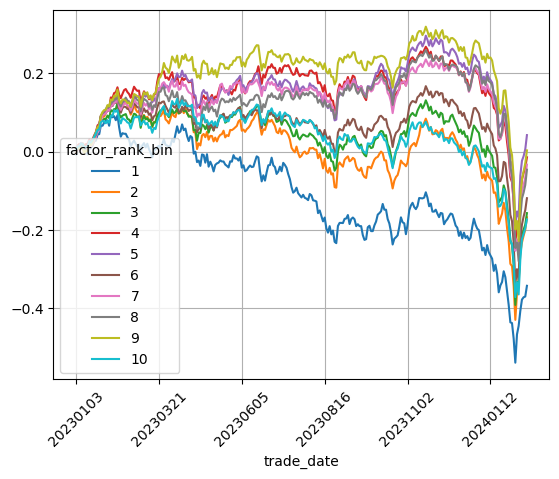

In [54]:
(test.groupby(['factor_rank_bin', \
        'trade_date']).ret1.mean()-1).unstack().T.cumsum().plot(rot=45,grid=True)

<AxesSubplot:xlabel='trade_date'>

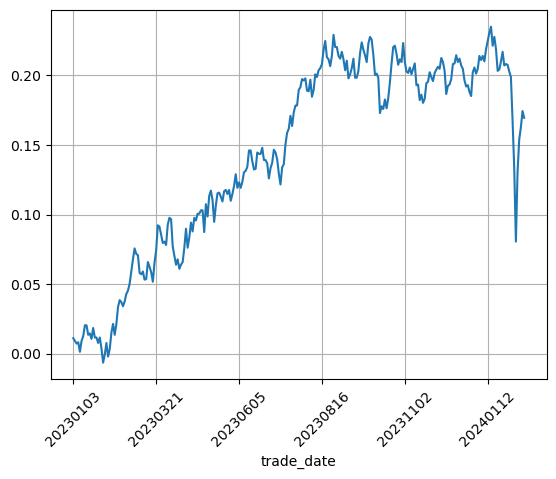

In [55]:
##计算做多做空收益
##做多factor最大的一组，做空factor最小的一组

long_ret = (test[(test.factor_rank_bin == 10)].groupby('trade_date').ret1.mean()-1).cumsum()
short_ret = (test[(test.factor_rank_bin == 1)].groupby('trade_date').ret1.mean()-1).cumsum()
(long_ret - short_ret).plot(rot=45,grid=True)

In [56]:
ret_PD = (test.groupby(['factor_rank_bin', 'trade_date']).ret1.mean()-1.00).unstack().T

if ret_PD[1].mean()>ret_PD[10].mean():
    ret_PD['diff'] = ret_PD[1] - ret_PD[10]
else:
    ret_PD['diff'] = ret_PD[10] - ret_PD[1]


In [57]:

def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min()
    end = returns.index[dd.argmin()]
    start = returns.index[r.loc[:end].argmax()]
    return mdd, start, end



 

def calc_pfmc(ret_PD):
    performance = []
    for i in [1,2,3,4,5,6,7,8,9,10,'diff']:
        returnlist = ret_PD[i]
        ret_year = (returnlist.mean()-0)*252
        ret_sharpe = (returnlist.mean()-0)/returnlist.std()*(252**0.5)
        max_draw, start, end = max_dd(returnlist)
        winratio = (returnlist>0).sum()/len(returnlist)
        std = returnlist.std()
        performance.append([i,ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])
    return performance

calc_pfmc(ret_PD)

,group_name,return,sharpe,std,winratio,mdd
0,1,-0.316509,-1.196585,0.016663,0.476190,-0.578613
1,2,-0.155010,-0.567324,0.017212,0.501832,-0.501953
2,3,-0.145157,-0.549782,0.016632,0.531136,-0.461914
3,4,-0.013518,-0.049432,0.017227,0.509158,-0.395996
4,5,0.038753,0.139118,0.017548,0.545788,-0.377930
5,6,-0.109949,-0.409668,0.016907,0.487179,-0.434082
6,7,-0.030642,-0.108212,0.017838,0.512821,-0.395508
7,8,-0.042808,-0.146784,0.018372,0.501832,-0.428223
8,9,0.002704,0.008937,0.019058,0.498168,-0.415039
9,10,-0.160057,-0.638431,0.015793,0.476190,-0.446289


## 固定买入N支

<AxesSubplot:title={'center':'2022-2024 year'}, xlabel='trade_date'>

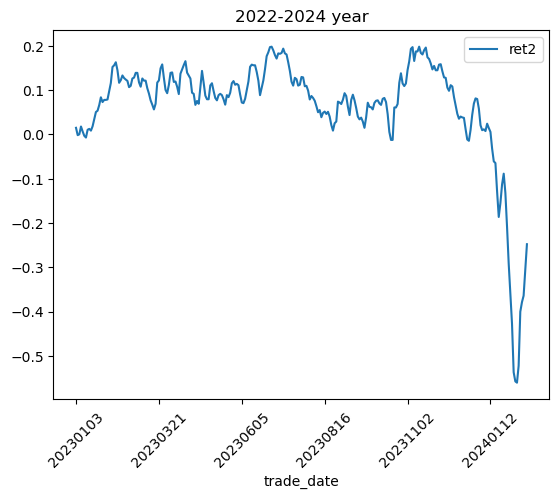

In [58]:
## 考虑t+1开盘买 t+2收盘卖的收益情况
tmp = test.copy()
tmp = tmp[~tmp.close.isna()].reset_index(drop=True)
# tmp = tmp[(tmp.open_up<1.05)&(tmp.open_up>0.95)] 
num = 10
tmp = tmp.groupby('trade_date').apply(lambda x: x.sort_values('factor_rank', ascending = False).head(num)).reset_index(drop=True)
ret_pd1 = pd.DataFrame(tmp.groupby('trade_date').ret2.mean() - 1.0005)
(ret_pd1.loc['20220101':,] ).cumsum().plot(rot=45, title = '2022-2024 year')


In [59]:
def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min().values[0]
    end = returns.index[dd.values.argmin()]
    start = returns.index[r.loc[:end].values.argmax()]
    return mdd, start, end


def calc_pfmc(ret_PD):
    ret_PD_ = ret_PD.copy()
    performance = []
    ret_PD_.columns = ['ret']
    returnlist = ret_PD_['ret']
    ret_year = (returnlist.mean())*252
    ret_sharpe = (returnlist.mean())/returnlist.std()*((252)**0.5)

    winratio = (returnlist>0).sum()/(returnlist!=0).sum()
    std = returnlist.std()
    
    ret2_len = pd.DataFrame(tmp.groupby('trade_date').ret.count())
    ret2_len = ret2_len.reindex(date_calc).fillna(0)
    stock_pct = ret2_len.mean().values[0]
    max_draw, start, end = max_dd(ret_PD)
    performance.append(['LGB',ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])
    
    

    return performance

In [60]:
calc_pfmc(ret_pd1) 

,group_name,return,sharpe,std,winratio,mdd
0,LGB,-0.22891,-0.621551,0.023193,0.462121,-0.632812


## 对冲收益

In [61]:
## 计算对冲的收益
dfindex = pro.index_daily(ts_code='000852.SH', start_date=ret_pd1.index[0], end_date=ret_pd1.index[-1])   #zz1000
# dfindex = pro.index_daily(ts_code='399905.SZ', start_date=ret_pd1.index[0], end_date=ret_pd1.index[-1])  #zz500
dfindex = dfindex[['trade_date','pct_chg']].set_index('trade_date').sort_index()
dfindex

,pct_chg
trade_date,
20230103,2.2618
20230104,-0.0377
20230105,0.9997
20230106,0.2290
20230109,0.5450
...,...
20240207,4.4726
20240208,4.0697
20240219,0.7306


In [62]:
ret_pd_concat = pd.merge(ret_pd1,dfindex/100,left_index=True, right_index=True)
ret_pd_concat.columns = ['ret','dfindex']
ret_pd_concat['diff'] = ret_pd_concat['ret'] - ret_pd_concat['dfindex']
ret_pd_concat

,ret,dfindex,diff
trade_date,,,
20230103,0.014648,0.022618,-0.007970
20230104,-0.016602,-0.000377,-0.016225
20230105,0.001953,0.009997,-0.008044
20230106,0.017578,0.002290,0.015288
20230109,-0.011230,0.005450,-0.016680
...,...,...,...
20240207,0.122070,0.044726,0.077344
20240208,0.021484,0.040697,-0.019213
20240219,0.014648,0.007306,0.007342


In [63]:
ret_pd_concat.corr()

,ret,dfindex,diff
ret,1.000000,0.205168,0.850024
dfindex,0.205168,1.000000,-0.341141
diff,0.850024,-0.341141,1.000000


<AxesSubplot:title={'center':'2022-2024 year'}, xlabel='trade_date'>

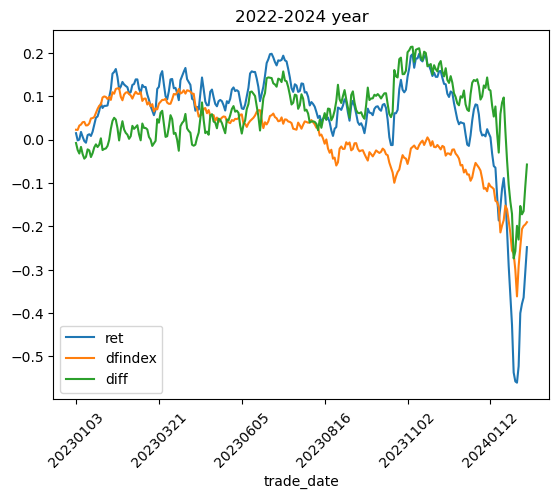

In [64]:
(ret_pd_concat[['ret','dfindex','diff']].cumsum()).plot(rot=45, title = '2022-2024 year')


In [65]:
calc_pfmc(ret_pd_concat[['diff']]) 

,group_name,return,sharpe,std,winratio,mdd
0,LGB,-0.05314,-0.138577,0.024156,0.479853,-0.402041
